# Age Detection with OpenCV



## Importing libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

## Building the age detection with pre-trained models

In [39]:
# Define the list of age range
AGE_RAN = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]

**Loading the face detection model**

In [40]:
prototxt = os.path.sep.join(["deploy.prototxt"])
weights = os.path.sep.join(["res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv.dnn.readNet(prototxt, weights)

**Loading the age detector model**

In [41]:
prototxtage = os.path.sep.join(["age_deploy.prototxt"])
weightsage = os.path.sep.join(["age_net.caffemodel"])
ageNet = cv.dnn.readNet(prototxtage, weightsage)

**Loading the images from the disk and making a list of images**

In [42]:
dataset =  os.path.abspath("dataset")
image_list = os.listdir(dataset)

In [43]:
image_list

['three_singers.jpeg',
 'milton.jpg',
 'gil.jpg',
 'caetano.jpg',
 'chico-buarque.jpg']

**Main loop for age predictions**

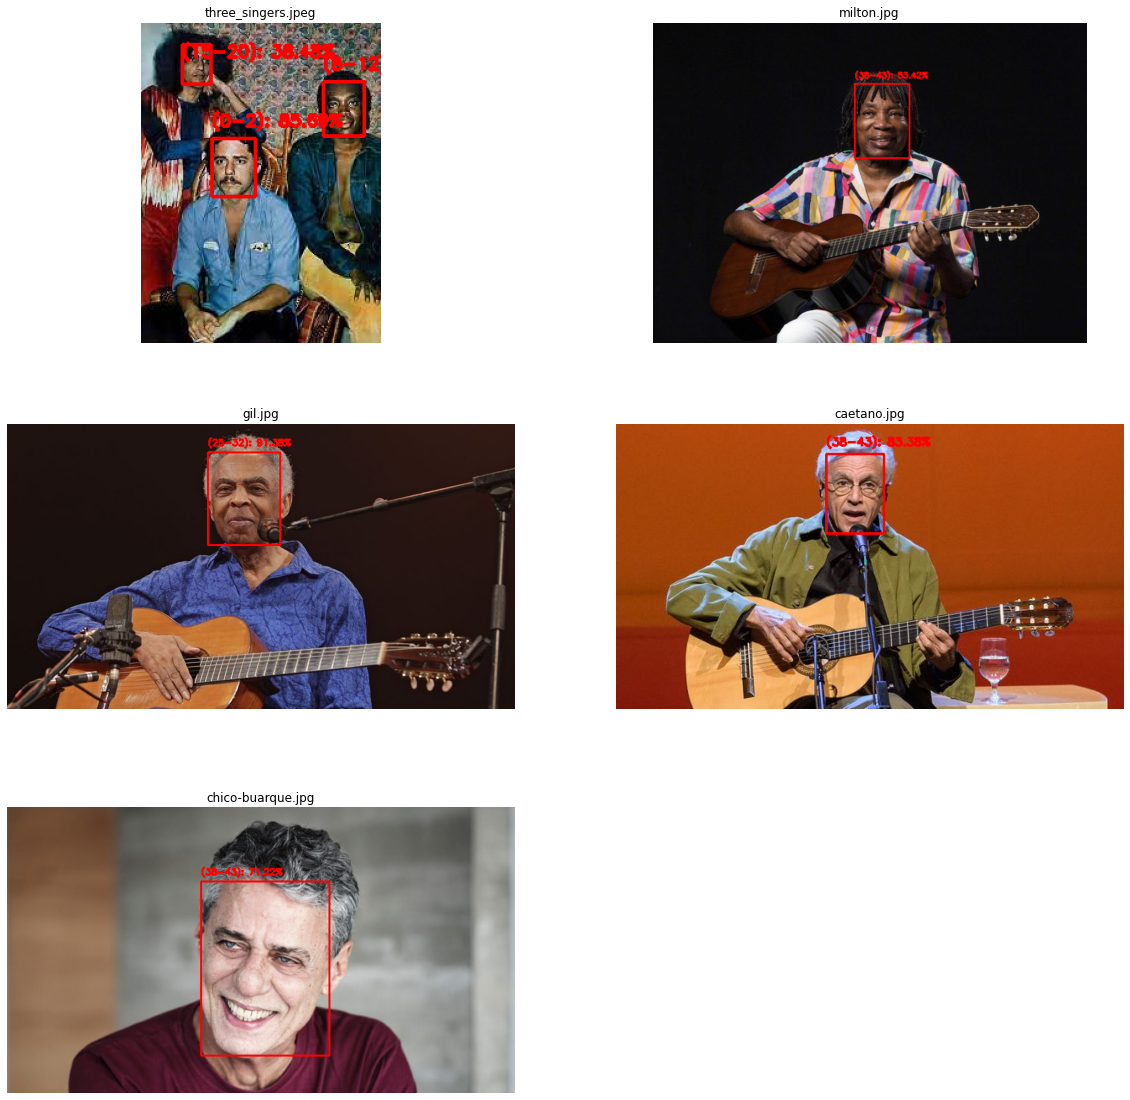

In [47]:
count = 1 # counter to build the pyplot display
plt.figure(figsize=(20, 20))

# Starting the main loop to make prediction for each image
for j in image_list:
    
    img = dataset + "/" + j # setting te image
    image = cv.imread(img) # reading the image with opencv
    (h, w) = image.shape[:2] # extacting the image coordinates
    
    blob = cv.dnn.blobFromImage(cv.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # Communicating the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    
    # Loop for the prediction on each image
    for i in range(0, detections.shape[2]):
        
        # Extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        
        # Filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > 0.5:
            
            # Compute the (x, y) - coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # Extract the ROI for the face detection and construct a blob from *only* the face ROI
            face = image[startY:endY, startX:endX]
            faceBlob = cv.dnn.blobFromImage(face, 1.0, (227, 227), (78.4263377603, 87.7689143744, 114.895847746),
                                             swapRB=False)
            
            # Make predictions on the age and find the age bucket with the largest corresponding probability
            ageNet.setInput(faceBlob)
            preds = ageNet.forward()
            i = preds[0].argmax()
            age = AGE_RAN[i]
            ageConfidence = preds[0][i]
            
            # Display the predicted age to the terminal
            text = "{}: {:.2f}%".format(age, ageConfidence * 100)
            
            # Draw the bounding box of the face along with the associated predicted age
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv.putText(image, text, (startX, y), cv.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
    ax = plt.subplot(3, 2, count)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(image_list[count-1])
    plt.axis("off")
    count += 1

plt.savefig("age_prediction.jpg")
plt.show()
